# MNIST dataset practice (Pytorch)

## Importing neccessary libs

In [1]:
import torch
import torchvision

## Setting global vars

In [2]:
n_epochs = 3
batch_size_tr = 64
batch_size_te = 1200
lr = 0.01
momentum = 0.5
log_inter = 10
r_seed = 74
torch.backends.cudnn.enabled = False
torch.manual_seed(r_seed)


## Train and test loaders

In [3]:
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/data/', download= True, train= True,
                                           transform= torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.13,), (0.308))])),
                                           batch_size= batch_size_tr, shuffle= True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/data/', download= True, train= False,  
                                           transform= torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.13,), (0.308))])),
                                          batch_size= batch_size_te, shuffle= True,)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



In [4]:
# Show examples

imgs = enumerate(train_loader)

index, (ex_data, ex_targets) = next(imgs)

ex_data.shape


torch.Size([64, 1, 28, 28])

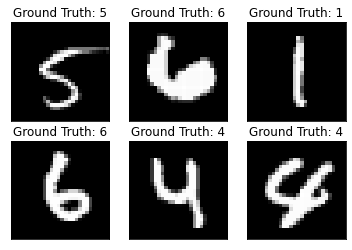

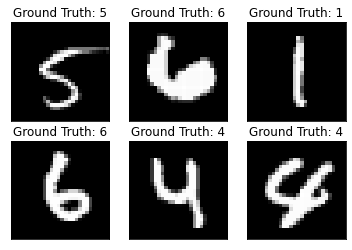

In [5]:
# Visualize examples
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(ex_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(ex_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Network (self-made)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 15, kernel_size= 3)
    self.conv2 = nn.Conv2d(15, 20, kernel_size= 3)
    self.conv3 = nn.Conv2d(20, 30, kernel_size= 3)

    self.conv2_dropout = nn.Dropout2d()
    self.conv3_dropout = nn.Dropout2d()

    self.pool1 = nn.MaxPool2d(kernel_size= 2)

    self.fc1 = nn.Linear(2430, 1200)
    self.fc2 = nn.Linear(1200, 600)
    self.fc3 = nn.Linear(600 ,300)
    self.fc4 = nn.Linear(300, 10)


  def forward(self, x):
    x = F.relu(self.pool1(self.conv1(x)))
    x = F.relu(self.conv2_dropout(self.conv2(x)))
    x = F.relu(self.conv3_dropout(self.conv3(x)))

    x = x.view(-1, 2430)

    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    
    x = F.relu(self.fc2(x))
    x = F.dropout(x, training=self.training)

    x = F.relu(self.fc3(x))
    x = F.dropout(x, training=self.training)

    x = self.fc4(x)
    
    return F.log_softmax(x)

In [8]:
net = ConvNet()
optimizer = optim.SGD(net.parameters(), lr= lr, momentum= momentum)

In [9]:
net.to('cuda')

ConvNet(
  (conv1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv2_dropout): Dropout2d(p=0.5, inplace=False)
  (conv3_dropout): Dropout2d(p=0.5, inplace=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2430, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=10, bias=True)
)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

### Train phase

In [11]:
def train(epoch):
  net.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to('cuda')
    target = target.to('cuda')

    optimizer.zero_grad()
    output = net(data)

    loss = F.nll_loss(output, target)
    loss.backward()

    optimizer.step()

    if batch_idx % log_inter == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(net.state_dict(), '/results/model.pth')            Used when continue training
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')  Used when continue training

In [12]:
def test():
  net.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to('cuda')
      target = target.to('cuda')

      output = net(data)

      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3028, Accuracy: 1037/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302764
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.306313
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.300954
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.302575
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.300755
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.288886
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.298397
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.306688
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.298748
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.304165
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.303114
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.301424
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.303686
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.301528
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.306009
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.300443
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.296452
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.296457
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.299137
Train Epoch: 1 [12160

## Evaluating perfomance

Text(0, 0.5, 'negative log likelihood loss')

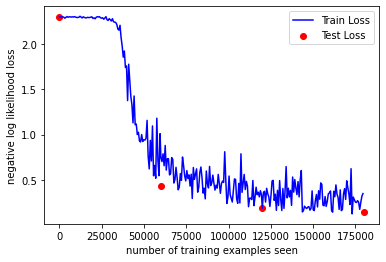

In [17]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
